<a href="https://colab.research.google.com/github/breakthrougher/FaceRecognition/blob/master/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf FaceRecognition

In [2]:
! git clone https://github.com/breakthrougher/FaceRecognition/

Cloning into 'FaceRecognition'...
remote: Enumerating objects: 10774, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 10774 (delta 3), reused 5 (delta 0), pack-reused 10761 (from 1)
Receiving objects: 100% (10774/10774), 222.75 MiB | 15.13 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (10740/10740), done.


In [3]:
%cd FaceRecognition

/content/FaceRecognition


In [4]:
!python net_npy_AR.py

(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)
(100, 80, 3)

In [5]:
!python net_npy_Video.py

X.shape: (2400, 150, 150, 3)
y.shape: (2400,)
X.shape: (5194, 150, 150, 3)
y.shape: (5194,)


In [ ]:
import cv2
import numpy as np
import os
from sklearn.decomposition import PCA as Sklearn_PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import json
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

component = 28
Neighbors = 6
scale = 1.1

# 伽马矫正
def gamma_correction(image, gamma):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# 数据格式为按列
def PCA(X_train, components):
    # Prepare
    col = X_train.shape[1]
    # axis=0 表示操作是针对行的方向，但实际上是在处理特征（列）
    Mean = np.mean(X_train, axis=1)
    # X = X_train - Mean
    # 减去每个特征的均值,使得每个特征的均值均为0
    X = X_train - Mean[:, np.newaxis]
    # Calculate eig_vectors, eig_values
    cov = np.dot(X, X.T) / col
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # 确保特征值、特征向量为实数
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)

    # 对特征值、特征向量进行排序
    index = np.argsort(eigenvalues)[::-1]
    # 大小为样本数量*样本数量
    W = eigenvectors[:, index]

    # Build model
    model = {
        'mean': Mean,
        'W': W[:, :components],
        'components': components
    }

    return model

# 加载人脸检测模型
face_mode = cv2.CascadeClassifier("ckpt/haarcascade_frontalface_alt.xml")

# 训练集和测试集
train_path = "train_samples"
train_images = []
train_labels = []
train_num = 0

# 人脸检测
for label in os.listdir(train_path):
    label_path = os.path.join(train_path, label)
    num = 0
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            # 转为灰度图
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_mode.detectMultiScale(gray_img, scaleFactor=scale, minNeighbors=Neighbors)
            # 二次探查
            if len(faces) == 0:
                blurred_image = cv2.GaussianBlur(gray_img, (3, 3), 0)
                faces = face_mode.detectMultiScale(blurred_image, scaleFactor=scale, minNeighbors=Neighbors)
                # 三次探查
                if len(faces) == 0:
                    histed_image = cv2.equalizeHist(blurred_image)
                    faces = face_mode.detectMultiScale(histed_image, scaleFactor=scale, minNeighbors=Neighbors)
                    # 四次探查
                    if len(faces) == 0:
                        gamma_image = gamma_correction(histed_image, 1.5)
                        faces = face_mode.detectMultiScale(gamma_image, scaleFactor=scale, minNeighbors=Neighbors)

            # print(f"Image: {img_name}, Detected faces: {len(faces)}")
            for (x, y, w, h) in faces:
                face = gray_img[y:y+h, x:x+w]
                face_sized = cv2.resize(face, (150, 150))
                train_images.append(face_sized.flatten())
                train_labels.append(label)
        train_num += 1


# 将训练数据转为numpy数组
X_train = np.array(train_images)
y_train = np.array(train_labels)

print(f"Detected Train faces num are: {X_train.shape[0]}/{train_num}")

# sklearn库中的PCA进行特征提取
pca = Sklearn_PCA(n_components=component)
x_train_pca = pca.fit_transform(X_train)
project_matrix = pca.components_

# 使用自定义PCA进行特征提取
# model = PCA(X_train.transpose(), components=component)
# x_train_pca = X_train.dot(model['W'])
# print(x_train_pca.shape)

# 读取测试集
test_images = []
test_labels = []
test_path = "test_samples"
test_num = 0
faces_num = 0
labels_detect_num = []
num = 0
for label in os.listdir(test_path):
    label_path = os.path.join(test_path, label)
    num = 0
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            # 转为灰度图
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_mode.detectMultiScale(gray_img, scaleFactor=scale, minNeighbors=Neighbors)
            # 二次探查
            if len(faces) == 0:
                blurred_image = cv2.GaussianBlur(gray_img, (3, 3), 0)
                faces = face_mode.detectMultiScale(blurred_image, scaleFactor=scale, minNeighbors=Neighbors)
                # 三次探查
                if len(faces) == 0:
                    histed_image = cv2.equalizeHist(blurred_image)
                    faces = face_mode.detectMultiScale(histed_image, scaleFactor=scale, minNeighbors=Neighbors)
                    # 四次探查
                    if len(faces) == 0:
                        gamma_image = gamma_correction(histed_image, 1.5)
                        faces = face_mode.detectMultiScale(gamma_image, scaleFactor=scale, minNeighbors=Neighbors)

            for (x, y, w, h) in faces:
                face = gray_img[y:y+h, x:x+w]
                face_sized = cv2.resize(face, (150, 150))
                test_images.append(face_sized.flatten())
                test_labels.append(label)
                faces_num += 1

                # 绘制矩形框并保存图像
                # cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # 红色矩形框
                # output_folder = "test_faces"
                # if not os.path.exists(output_folder):
                #     os.makedirs(output_folder)
                # output_folder = os.path.join(output_folder, label)
                # if not os.path.exists(output_folder):
                #     os.makedirs(output_folder)
                # cv2.imwrite(os.path.join(output_folder, img_name), img)
                num += 1

        test_num += 1
    labels_detect_num.append(num)
print(f"Detected Test faces num are: {faces_num}/{test_num}")

# 将测试数据转为numpy数组
X_test = np.array(test_images)
y_test = np.array(test_labels)

x_test_pca = pca.transform(X_test)
# x_test_pca = X_test.dot(model['W'])
print("PCA Component:", component)
print("Neighbour", Neighbors)
print("Scale",scale)

################################### 分类器 ##################################

# KNN训练和识别
knn = KNeighborsClassifier()
knn.fit(x_train_pca, y_train)
predictions = knn.predict(x_test_pca)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy is {accuracy*100:.2f}")
print("KNN accuarcy:",accuracy)

# 高斯朴素贝叶斯分类器
nb = GaussianNB()
nb.fit(x_train_pca, y_train)
predictions = nb.predict(x_test_pca)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy is {accuracy*100:.2f}")
print("GaussianNB accuarcy:",accuracy)

# 支持向量机
svm = SVC(kernel='rbf',gamma='scale')
svm.fit(x_train_pca,y_train)
predictions = svm.predict(x_test_pca)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy is {accuracy*100:.2f}")
print("SVM accuarcy:",accuracy)

# 随机森林
rf = RandomForestClassifier()
rf.fit(x_train_pca, y_train)
predictions = rf.predict(x_test_pca)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy is {accuracy*100:.2f}")
print("RandomForest accuarcy:",accuracy)

# XGBoost
xgb = XGBClassifier()
y_test = y_test.astype(int)
y_train = y_train.astype(int)
xgb.fit(x_train_pca, y_train)
predictions = xgb.predict(x_test_pca)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy is {accuracy*100:.2f}")
print("XGBoost accuarcy:",accuracy)

# # 创建一个字典以保存标签和预测结果
# results_dict = {
#     'True Labels': y_test.tolist(),  # 转换为列表以便于序列化
#     'Predictions': predictions.tolist(),
#     'class nums':labels_detect_num
# }

# # 保存为 JSON 文件
# with open('results.json', 'w') as json_file:
#     json.dump(results_dict, json_file, indent=4)
# print("标签和预测结果已保存到results.json")

Detected Train faces num are: 2178/2400
Detected Test faces num are: 3898/5194
PCA Component: 28
Neighbour 6
Scale 1.1
Accuracy is 84.84
KNN accuarcy: 0.8483837865572088
Accuracy is 56.52
GaussianNB accuarcy: 0.5651616213442792
Accuracy is 88.79
SVM accuarcy: 0.887891226269882
Accuracy is 77.45
RandomForest accuarcy: 0.7744997434581837
Accuracy is 77.04
XGBoost accuarcy: 0.7703950743971267


In [6]:
# 准备三维数据
!python get_feature_test.py
!python get_feature_train.py

流式输出内容被截断，只能显示最后 5000 行内容。
face shape: (102, 102)
face shape: (133, 133)
face shape: (135, 135)
face shape: (147, 147)
face shape: (102, 102)
face shape: (140, 140)
face shape: (94, 94)
face shape: (171, 171)
face shape: (96, 96)
face shape: (172, 172)
face shape: (141, 141)
face shape: (95, 95)
face shape: (135, 135)
face shape: (128, 128)
face shape: (91, 91)
face shape: (162, 162)
face shape: (153, 153)
face shape: (121, 121)
face shape: (156, 156)
face shape: (91, 91)
face shape: (134, 134)
face shape: (139, 139)
face shape: (91, 91)
face shape: (145, 145)
face shape: (143, 143)
face shape: (91, 91)
face shape: (144, 144)
face shape: (132, 132)
face shape: (136, 136)
face shape: (145, 145)
face shape: (134, 134)
face shape: (146, 146)
face shape: (133, 133)
face shape: (151, 151)
face shape: (93, 93)
face shape: (153, 153)
face shape: (113, 113)
face shape: (136, 136)
face shape: (153, 153)
face shape: (90, 90)
face shape: (126, 126)
face shape: (172, 172)
face shape: (96, 96)
face

In [ ]:
# DCN121网络（稠密卷积神经网络）
!python haar_based/DCN.py

Train samples shape: (2178, 150, 150)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100% 30.8M/30.8M [00:00<00:00, 179MB/s]
Epoch 1/10: 100%|███████████████████████████████████████████████████| 35/35 [00:12<00:00,  2.86it/s]
Epoch 1/10, Loss: 0.4576, Accuracy: 92.24%
Epoch 2/10

In [ ]:
# Resnet18网络（残差卷积神经网络）
!python haar_based/ResNet.py

Train samples shape: (2178, 150, 150)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 193MB/s]
Epoch 1/10: 100%|███████████████████████████████████████████████████| 35/35 [00:04<00:00,  8.74it/s]
Epoch 1/10, Loss: 0.2439, Accuracy: 94.86%
Epoch 2/10: 100%|█████

In [ ]:
# GoogleNet网络（谷歌卷积神经网络）
!python haar_based/GoogleNet.py

Train samples shape: (2178, 150, 150)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100% 49.7M/49.7M [00:00<00:00, 120MB/s]
Epoch 1/10: 100%|███████████████████████████████████████████████████| 35/35 [00:05<00:00,  6.45it/s]
Epoch 1/10, Loss: 0.8404, Accuracy: 87.37%
Epoch 2/10: 100%|█

In [ ]:
# VGG19网络（视觉几何组神经网络）
!python haar_based/VGG.py

Train samples shape: (2178, 150, 150)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100% 548M/548M [00:05<00:00, 104MB/s]
Epoch 1/10: 100%|███████████████████████████████████████████████████| 35/35 [00:21<00:00,  1.60it/s]
Epoch 1/10, Loss: 0.2411, Accuracy: 93.43%
Epoch 2/10: 100%|███████

In [7]:
!pip install insightface
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 98.0 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1055382 sha256=ca372bb4dda2f41544de4cc8bbb429bcac648b2b66a3710040c65f894ab54bb8
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.3 MB/s eta 0:00:00


In [8]:
# ArcFace特征
# test
!python arcface_video.py

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
download_path: /root/.insightface/models/buffalo_l
100% 281857/281857 [00:03<00:00, 89236.35KB/s]
/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightf

In [9]:
# ArcFace特征
# train
!python arcface_video.py

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers

In [10]:
!python haar_based/Arcface_feature_classify.py

/content/FaceRecognition/haar_based/Arcface_feature_classify.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train = torch.load("Vidface_three_dimension/arcface_F_tra

In [12]:
# PCA+ArcFace
!python arcface_vid_predict.py

/content/FaceRecognition/arcface_vid_predict.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train = torch.load("Vidface_three_dimension/arcface_F_train.pth").to(devi

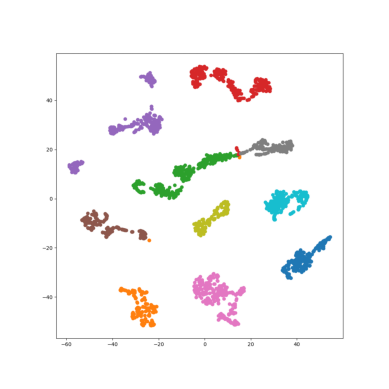

In [17]:
import cv2
import matplotlib.pyplot as plt

# 读取图像
image = cv2.imread('arcface_tsne_test.png')

# 将图像从 BGR 转换为 RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 使用 matplotlib 显示图像
plt.imshow(image)
plt.axis('off')  # 不显示坐标轴
plt.show()

In [ ]:
# AR数据集

In [18]:
!python arcface_AR.py

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/content/FaceRecognition/arcface_AR.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seria

In [19]:
# densenet
!python main_net.py

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100% 30.8M/30.8M [00:00<00:00, 170MB/s]
/content/FaceRecognition/main_net.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is

In [20]:
# resnet
!python main_net.py

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100% 171M/171M [00:01<00:00, 175MB/s]
/content/FaceRecognition/main_net.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible 

In [ ]:
# vgg
!python main_net.py

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100% 548M/548M [00:05<00:00, 105MB/s]
/content/FaceRecognition/main_net.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to c

In [ ]:
# googlenet
!python main_net.py